# Практические задания по SQL.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine 
import seaborn as sns


Подключение к базе данных.

In [3]:
db_config = {
    'user': 'praktikum_student', # имя пользователя
    'pwd': 'Sdf4$2;d-d30pp', # пароль
    'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
    'port': 6432, # порт подключения
    'db': 'data-analyst-advanced-sql' # название базы данных
}  

connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)

Создание подключения

In [4]:
engine = create_engine(connection_string) 

In [5]:
query = '''
SELECT *
FROM stackoverflow.users
LIMIT 10;
'''

sample_df = pd.read_sql_query(query, con=engine) 

In [6]:
sample_df

,id,creation_date,display_name,last_access_date,location,reputation,views
0,1,2008-07-31 14:22:31,Jeff Atwood,2018-08-29 02:34:23,"El Cerrito, CA",44300,408587
1,2,2008-07-31 14:22:31,Geoff Dalgas,2018-08-23 17:31:56,"Corvallis, OR",3491,23966
2,3,2008-07-31 14:22:31,Jarrod Dixon,2018-08-30 20:56:24,"Raleigh, NC, United States",13418,24396
3,4,2008-07-31 14:22:31,Joel Spolsky,2018-08-14 22:18:15,"New York, NY",28768,73755
4,5,2008-07-31 14:22:31,Jon Galloway,2018-08-29 16:48:36,"San Diego, CA",39172,11700
5,8,2008-07-31 21:33:24,Eggs McLaren,2018-04-09 02:04:56,None,942,6372
6,9,2008-07-31 21:35:27,Kevin Dente,2018-08-30 18:18:03,"Oakland, CA",14337,4949
7,11,2008-08-01 00:59:11,Anonymous User,2008-08-01 00:59:11,None,1890,2123
8,13,2008-08-01 04:18:05,Chris Jester-Young,2018-08-30 02:47:23,"Raleigh, NC, United States",177138,35414
9,17,2008-08-01 12:02:22,Nick Berardi,2018-01-22 01:35:38,"Issaquah, WA",44443,4786


### Задание 1

Выведите общую сумму просмотров постов за каждый месяц 2008 года. Если данных за какой-либо месяц в базе нет, такой месяц можно пропустить. Результат отсортируйте по убыванию общего количества просмотров.

| month_date  | total_views |
| ------------- | ------------- |
| 2008-09-01  | 452928568  |
| 2008-10-01  | 365400138  |
| ...         | ... |

In [34]:
# напишите запрос
query = '''
SELECT CAST(DATE_TRUNC('month', creation_date) AS date) AS month_date,
       SUM(views_count) AS total_views
FROM stackoverflow.posts
GROUP BY CAST(DATE_TRUNC('month', creation_date) AS date)
ORDER BY SUM(views_count) DESC;
'''

# выполните запрос
sample_df_1 = pd.read_sql_query(query, con=engine) 

In [35]:
sample_df_1

,month_date,total_views
0,2008-09-01,452928568
1,2008-10-01,365400138
2,2008-11-01,221759651
3,2008-12-01,197792841
4,2008-08-01,131367083
5,2008-07-01,669895


 - вывод по Заданию 1:
 
Анализируя таблицу видно, что самая большая активность по просмотрам приходится на сентябрь-октябрь, летом отмечается очень низкая активность, к концу года тоже заметен спад. То есть на активность пользователей влияет сезонность.

### Задание 2

Выведите список имён самых активных пользователей, которые в первый месяц после регистрации (включая день регистрации) дали больше 100 ответов. Вопросы, которые задавали пользователи, не учитывайте. Отсортируйте результат по полю с именами в лексикографическом порядке.

| display_name |
| ------------ |
| 1800 INFORMATION |
| Adam Bellaire |
| Adam Davis |
| ... |

In [9]:
# напишите запрос
query = '''

SElECT u.display_name

FROM stackoverflow.users AS u

JOIN stackoverflow.posts AS p ON u.id = p.user_id
JOIN stackoverflow.post_types AS p_t ON p.post_type_id = p_t.id 

WHERE (p_t.type = 'Answer') 
AND p.creation_date >= DATE_TRUNC('day', u.creation_date) 
AND p.creation_date <= DATE_TRUNC('day', u.creation_date) + INTERVAL '1 month'


GROUP BY u.display_name 
 

HAVING (COUNT(p.id) > 100) 

ORDER BY u.display_name

; 
'''

# выполните запрос
sample_df_2 = pd.read_sql_query(query, con=engine) 

In [10]:
sample_df_2.head()

,display_name
0,1800 INFORMATION
1,Adam Bellaire
2,Adam Davis
3,Adam Liss
4,Alan


### Задание 3

Выведите количество постов за 2008 год по месяцам. Отберите посты от пользователей, которые зарегистрировались в сентябре 2008 года и сделали хотя бы один пост в декабре того же года. Отсортируйте таблицу по значению месяца по убыванию.

| month | count |
| ------|------ |
| 2008-12-01 | 17641 |
| 2008-11-01 | 182984 |
| ... | ... |

In [11]:
# напишите запрос
query = '''
SELECT CAST(DATE_TRUNC ('month', p.creation_date) AS date) AS month,
        COUNT (p.id) AS count

FROM stackoverflow.users AS u

INNER JOIN stackoverflow.posts AS p ON u.id = p.user_id



WHERE u.id IN (SELECT u.id AS user
       
FROM stackoverflow.users AS u

INNER JOIN stackoverflow.posts AS p ON u.id = p.user_id

WHERE (CAST(DATE_TRUNC ('month', u.creation_date) AS date) = '2008-09-01') 
AND (CAST(DATE_TRUNC ('month', p.creation_date) AS date) = '2008-12-01')

GROUP BY u.id)

GROUP BY CAST(DATE_TRUNC ('month', p.creation_date) AS date)
ORDER BY CAST(DATE_TRUNC ('month', p.creation_date) AS date) DESC;


'''

# выполните запрос
sample_df_3 = pd.read_sql_query(query, con=engine) 

In [12]:
sample_df_3

,month,count
0,2008-12-01,17641
1,2008-11-01,18294
2,2008-10-01,27171
3,2008-09-01,24870
4,2008-08-01,32


- Вывод по заданию 3:
 
 Согласно таблице аномалией является количество постов в августе у пользователей, которые зарегистрировались только в сентябре. Скорее всего какая то некорректность в исходных данных.

### Задание 4

Используя данные о постах, выведите несколько полей:

- идентификатор пользователя, который написал пост;
- дата создания поста;
- количество просмотров у текущего поста;
- сумму просмотров постов автора с накоплением.

Данные в таблице должны быть отсортированы по возрастанию идентификаторов пользователей, а данные об одном и том же пользователе — по возрастанию даты создания поста.

| user_id | creation_date | views_count | cumulative_count |
| ------ | -------------- | ----------- | ---------------- |
| 1 | 2008-07-31 23:41:00  | 480476   | 480476  |
| 1 | 2008-07-31 23:55:38  | 136033 | 616509  | 
| 1 | 2008-07-31 23:56:41  | 0 |  616509  |
| ... | ... | ... | ... |
| 2 | 2008-07-31 23:56:41 | 79087  | 79087 |
| 2 | 2008-08-01 05:09:56 | 65443 | 144530 |
| ... | ...  | ...  | ...  |

In [13]:
# напишите запрос
query = '''
SElECT 
       u.id AS user_id,
       p.creation_date,
       p.views_count,
       SUM(p.views_count) OVER (PARTITION BY u.id ORDER BY p.creation_date)
FROM stackoverflow.users AS u

INNER JOIN stackoverflow.posts AS p ON u.id = p.user_id 

ORDER BY u.id, p.creation_date;
'''

# выполните запрос
sample_df_4 = pd.read_sql_query(query, con=engine) 

In [14]:
sample_df_4

,user_id,creation_date,views_count,sum
0,1,2008-07-31 23:41:00,480476,480476
1,1,2008-07-31 23:55:38,136033,616509
2,1,2008-07-31 23:56:41,0,616509
3,1,2008-08-04 02:45:08,0,616509
4,1,2008-08-04 04:31:03,0,616509
...,...,...,...,...
243791,5696608,2008-12-23 16:00:37,0,2804
243792,5696608,2008-12-23 17:35:09,0,2804
243793,5696608,2008-12-24 01:02:48,0,2804
243794,5696608,2008-12-30 14:34:45,0,2804


### Задание 5

Найдите среднее количество постов пользователей в день за август 2008 года. Отберите данные о пользователях, которые опубликовали больше 120 постов за август. Дни без публикаций не учитывайте. 

Отсортируйте результат по возрастанию среднего количества постов. Значения можно не округлять.

| user_id | avg_daily |
| ------- | --------- |
| 116     | 4.8076923076923077 |
| 234     | 5.3043478260869565 |
| ...     | ... |

In [15]:
# напишите запрос
query = '''
WITH srez AS
(SELECT u.id AS users,
       CAST(DATE_TRUNC('day', p.creation_date) AS date) AS day,
       COUNT(p.id) AS count_p
       
       
FROM stackoverflow.users AS u
INNER JOIN stackoverflow.posts AS p ON u.id = p.user_id 

WHERE CAST(DATE_TRUNC('day', p.creation_date) AS date) >= '2008-08-01' 
AND CAST(DATE_TRUNC('day', p.creation_date) AS date) <= '2008-08-31'

GROUP BY u.id, CAST(DATE_TRUNC('day', p.creation_date) AS date)
ORDER BY u.id)

SELECT users,
       AVG(count_p)
       
FROM srez
 
GROUP BY users
HAVING SUM(count_p) > 120
ORDER BY AVG(count_p)
;'''

# выполните запрос
sample_df_5 = pd.read_sql_query(query, con=engine)

In [16]:
sample_df_5

,users,avg
0,116,4.777778
1,234,5.208333
2,91,5.681818
3,905,7.000000
4,383,7.277778


In [17]:
q = """select CAST(DATE_TRUNC('day', now()) AS date) as with_cast,
                DATE_TRUNC('day', now()) no_cast,
                CAST(DATE_TRUNC('day', now()) AS date) = DATE_TRUNC('day', now()) as is_equal"""
pd.read_sql_query(q, con=engine)

,with_cast,no_cast,is_equal
0,2021-12-10,2021-12-09 21:00:00+00:00,True


### Задание 6

Сколько в среднем дней в период с 1 по 7 декабря 2008 года включительно пользователи взаимодействовали с платформой? Для каждого пользователя отберите дни, в которые он или она опубликовали хотя бы один пост. Нужно получить одно целое число — не забудьте округлить результат. 

| result |
| -----  |
| <целое число> |

In [18]:
# напишите запрос
query = '''
WITH srez AS
(SELECT 
       user_id,
       COUNT(DISTINCT(DATE_TRUNC('day',creation_date))) AS count
FROM stackoverflow.posts


WHERE CAST(DATE_TRUNC('day', creation_date) AS date) >= '2008-12-01' 
AND CAST(DATE_TRUNC('day', creation_date) AS date) <= '2008-12-07'
GROUP BY user_id)

SELECT ROUND(AVG(count), 0) AS result
FROM srez
;
'''


# выполните запрос
sample_df_6 = pd.read_sql_query(query, con=engine)

In [19]:
sample_df_6

,result
0,2.0


- Вывод по заданию 6:

Согласно анализа за исследуемую неделю декабря 2008 года в среднем на каждого пользователя приходится 2 активных дня в неделю - очень низкий показатель. Необходимо исследовать этот показатель в другие временные периоды.  

### Задание 7

Выведите историю активности каждого пользователя в таком виде: идентификатор пользователя, дата публикации поста. Отсортируйте вывод по возрастанию идентификаторов пользователей, а для каждого пользователя — по возрастанию даты публикации.

Добавьте в таблицу новое поле: для каждого поста в нём будет указано название месяца предпоследней публикации пользователя относительно текущей. Если такой публикации нет, укажите `NULL`.

Посмотрите внимательно на образец таблицы: для первых двух постов предпоследней публикации нет, но, начиная с третьего поста, в новое поле входит нужный месяц. Для следующего пользователя в первые две записи поля `second_last_month` тоже войдёт `NULL`.

| user_id | creation_date | second_last_month |
| ------- | ------------- | ----------------- |
| 1       | 2008-07-31 23:41:00 | NULL |
| 1       | 2008-07-31 23:55:38 | NULL |
| 1       | 2008-07-31 23:56:41 | Июль |
| 1       | 2008-08-04 02:45:08 | Июль |
| 1       | 2008-08-04 04:31:03 | Июль |
| 1       | 2008-08-04 08:04:42 | Август |
| ... | ... | ... |

In [20]:
# напишите запрос
query = '''

WITH srez AS
(SELECT user_id,
       creation_date :: date,
       (LAG(EXTRACT( MONTH FROM creation_date), 2, NULL) 
       OVER (PARTITION BY user_id ORDER BY creation_date :: date)) AS second_last_month
FROM stackoverflow.posts  
ORDER BY user_id, creation_date)

SELECT user_id,
       creation_date,
       CASE second_last_month
       WHEN 1.0 THEN 'Январь'
       WHEN 2.0 THEN 'Февраль'
       WHEN 3.0 THEN 'Март'
       WHEN 4.0 THEN 'Апрель'
       WHEN 5.0 THEN 'Май'
       WHEN 6.0 THEN 'Июнь'
       WHEN 7.0 THEN 'Июль'
       WHEN 8.0 THEN 'Август'
       WHEN 9.0 THEN 'Сентябрь'
       WHEN 10.0 THEN 'Октябрь'
       WHEN 11.0 THEN 'Ноябрь'
       WHEN 12.0 THEN 'Декабрь'
       END
FROM srez;
'''

# выполните запрос
sample_df_7 = pd.read_sql_query(query, con=engine)

In [21]:
sample_df_7

,user_id,creation_date,case
0,1,2008-07-31,None
1,1,2008-07-31,None
2,1,2008-07-31,Июль
3,1,2008-08-04,Июль
4,1,2008-08-04,Июль
...,...,...,...
243791,5696608,2008-12-23,Декабрь
243792,5696608,2008-12-23,Декабрь
243793,5696608,2008-12-24,Декабрь
243794,5696608,2008-12-30,Декабрь


### Задание 8

Рассчитайте аналог Retention Rate по месяцам для пользователей StackOverflow. Объедините пользователей в когорты по месяцу их первого поста. Возвращение определяйте по наличию поста в текущем месяце. 

| cohort_dt | session_date | users_cnt | cohort_users_cnt | retention_rate |
| --------- | ------------ | --------- | ---------------- | -------------- |
| 2008-07-01 00:00:00 | 2008-07-01 00:00:00 | 3 | 3 | 100 |
| 2008-07-01 00:00:00 | 2008-08-01 00:00:00 | 2 | 3 | 66,67 |
| 2008-07-01 00:00:00 | 2008-09-01 00:00:00 | 1 | 3 | 33,33 |
| 2008-07-01 00:00:00 | 2008-10-01 00:00:00 | 2 | 3 | 66,67 |
| 2008-07-01 00:00:00 | 2008-11-01 00:00:00 | 1 | 3 | 33,33 |
| 2008-07-01 00:00:00 | 2008-12-01 00:00:00 | 2 | 3 | 66,67 |
| 2008-08-01 00:00:00 | 2008-08-01 00:00:00 | 2151 | 2151 | 100 | 
| ... | ... | ... | ... | ... |

In [22]:
# напишите запрос
query = '''

WITH profile AS
  (SELECT user_id,
          DATE_TRUNC('month', MIN(creation_date))::date AS start_mn,
          COUNT(*) OVER (PARTITION BY DATE_TRUNC('month', MIN(creation_date))::date ) AS cohort_users_cnt
   FROM stackoverflow.posts 
   GROUP BY 1),

sessions AS 
(SELECT user_id,
        DATE_TRUNC('month', creation_date)::date AS event_mn
FROM stackoverflow.posts 
GROUP BY 1,
         2)

SELECT p.start_mn cohort_dt,
       event_mn,
       COUNT(p.user_id) AS users_cnt,
       cohort_users_cnt,
       ROUND(COUNT(p.user_id) * 100.0 / cohort_users_cnt, 2) AS retention_rate
FROM profile p
JOIN sessions s ON p.user_id = s.user_id
GROUP BY 1,
         2,
         4;  




'''

# выполните запрос
sample_df_8 = pd.read_sql_query(query, con=engine)

In [23]:
sample_df_8.head()

,cohort_dt,event_mn,users_cnt,cohort_users_cnt,retention_rate
0,2008-07-01,2008-07-01,3,3,100.00
1,2008-07-01,2008-08-01,2,3,66.67
2,2008-07-01,2008-09-01,1,3,33.33
3,2008-07-01,2008-10-01,2,3,66.67
4,2008-07-01,2008-11-01,1,3,33.33


In [24]:
sample_df_8_1 = sample_df_8.pivot_table(index = 'cohort_dt', columns = 'event_mn', values = 'retention_rate')
sample_df_8_1

event_mn,2008-07-01,2008-08-01,2008-09-01,2008-10-01,2008-11-01,2008-12-01
cohort_dt,,,,,,
2008-07-01,100.0,66.67,33.33,66.67,33.33,66.67
2008-08-01,NaN,100.00,73.04,59.27,48.81,41.56
2008-09-01,NaN,NaN,100.00,53.82,38.63,32.56
2008-10-01,NaN,NaN,NaN,100.00,45.19,33.65
2008-11-01,NaN,NaN,NaN,NaN,100.00,40.36
2008-12-01,NaN,NaN,NaN,NaN,NaN,100.00


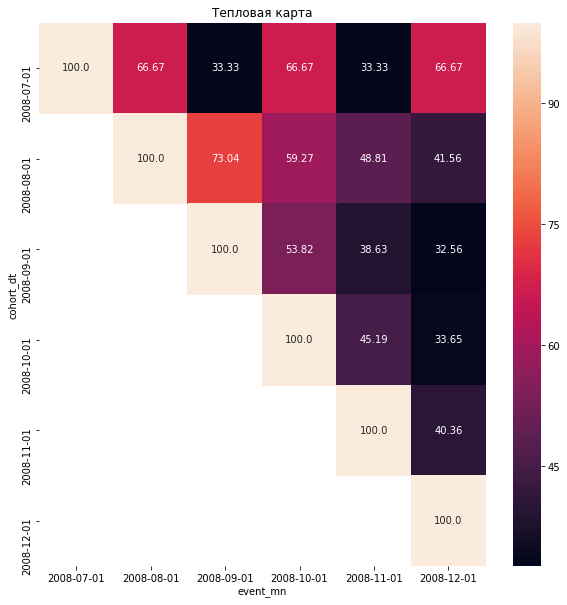

In [25]:
plt.figure(figsize=(10, 10)) # задаём размер графика
sns.heatmap(sample_df_8_1, # датафрейм с данными
            annot=True, # добавляем подписи
            fmt='') # задаём исходный формат
plt.title('Тепловая карта') # название графика
plt.show() 

Вывод по заданию 8:

- согласно тепловой карте, самый лучший показатель по удержанию во втором месяце показала когорта, привлеченная в августе 2008 года;
- выявлены аномалии в когорте, привлеченной в июле 2008 года: показатель удержания то растет, то падает на абсолютно одинаковые значения - необходим дополнительный анализ. и проверка исходных данных.

### Задание 9

На сколько процентов менялось количество постов ежемесячно с 1 сентября по 31 декабря 2008 года? Отобразите таблицу со следующими полями:

- номер месяца;
- количество постов за месяц;
- процент, который показывает, насколько изменилось количество постов в текущем месяце по сравнению с предыдущим.

Если постов стало меньше, значение процента должно быть отрицательным, если больше — положительным.

| creation_month | posts_count | percentage |
| -------------- | ----------- | ---------- |
| 9 | 70731 | NULL |
| 10 | 63102 | -11 |
| ... | ... | ... |

In [26]:
# напишите запрос
query = '''
SELECT EXTRACT(MONTH FROM creation_date) AS creation_month,
       COUNT(id) AS posts_count,
       (COUNT(id)*100 / LAG(COUNT(id)) OVER ()) - 100 AS percentage
FROM stackoverflow.posts 

WHERE (CAST (DATE_TRUNC ('day', creation_date) AS date)) >= '2008-09-01' 
AND (CAST (DATE_TRUNC ('day', creation_date) AS date))  <= '2008-12-31'

GROUP BY EXTRACT(MONTH FROM creation_date)
'''

# выполните запрос
sample_df_9 = pd.read_sql_query(query, con=engine)

In [27]:
sample_df_9

,creation_month,posts_count,percentage
0,9.0,70371,NaN
1,10.0,63102,-11.0
2,11.0,46975,-26.0
3,12.0,44592,-6.0


In [28]:
query = '''
select 125 / 17 as result;    
 '''
pd.read_sql_query(query, con=engine) 

,result
0,7


Постройте круговую диаграмму с количеством постов по месяцам.

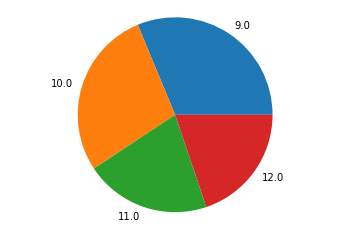

In [29]:
labels = sample_df_9['creation_month']
sizes = sample_df_9['posts_count']

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels)
ax1.axis('equal')  
plt.show()

Вывод по заданию 9:

- к концу года количество постов уменьшается.

### Задание 10

Выгрузите данные активности пользователя, который опубликовал больше всего постов за всё время. Выведите данные за октябрь 2008 года в таком виде:

- номер недели;
- дата и время последнего поста, опубликованного на этой неделе.

| week_creation | creation_date |
| ------------- | ------------- |
| 40 | 2008-10-05 09:00:58 |
| 41 | 2008-10-12 21:22:23 |
| ... | ... |

In [30]:
# напишите запрос
query = '''
WITH user_id AS
(SElECT DISTINCT user_id, 
                         COUNT(id)
                  FROM stackoverflow.posts 
                  GROUP BY user_id
                  ORDER BY COUNT(id) DESC
                  LIMIT 1),
date_week AS
(SELECT user_id,
       EXTRACT (WEEK FROM creation_date::date) AS week_creation, 
       creation_date           
FROM stackoverflow.posts                  
WHERE CAST (DATE_TRUNC ('month', creation_date) AS date) = '2008-10-01')

SELECT DISTINCT week_creation,
       MAX(creation_date) OVER (PARTITION BY week_creation)
FROM user_id AS u
LEFT JOIN date_week AS d_w ON u.user_id = d_w.user_id
GROUP BY week_creation, creation_date;         
'''

# выполните запрос
sample_df_10 = pd.read_sql_query(query, con=engine)

In [31]:
sample_df_10

,week_creation,max
0,40.0,2008-10-05 09:00:58
1,41.0,2008-10-12 21:22:23
2,42.0,2008-10-19 06:49:30
3,43.0,2008-10-26 21:44:36
4,44.0,2008-10-31 22:16:01
